In [1]:
# 04_final_evaluation_and_error_analysis.ipynb
# member 4 – final evaluation + error analysis

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    roc_auc_score,
    average_precision_score,
    roc_curve,
    precision_recall_curve,
    precision_recall_fscore_support
)

sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 5)

print("imports ok")


imports ok


In [3]:
# load provider-level dataset (created by member 2 / helper script)

data_path = "../data/provider_level_features.csv"

if not os.path.exists(data_path):
    raise FileNotFoundError(
        f"{data_path} not found. Make sure provider_level_features.csv is in the data/ folder."
    )

df = pd.read_csv(data_path)
print("data shape:", df.shape)
df.head()


data shape: (5410, 13)


,Provider,PotentialFraud,num_inpatient_claims,num_outpatient_claims,total_claims,ip_reimb_mean,ip_reimb_sum,ip_deduct_mean,ip_deduct_sum,op_reimb_mean,op_reimb_sum,op_deduct_mean,op_deduct_sum
0,PRV51001,No,5,20,25,19400.000000,97000.0,1068.0,5340.0,382.000000,7640.0,0.000000,0.0
1,PRV51003,Yes,62,70,132,9241.935484,573000.0,1068.0,66216.0,466.714286,32670.0,1.000000,70.0
2,PRV51004,No,0,149,149,NaN,NaN,NaN,NaN,350.134228,52170.0,2.080537,310.0
3,PRV51005,Yes,0,1165,1165,NaN,NaN,NaN,NaN,241.124464,280910.0,3.175966,3700.0
4,PRV51007,No,3,69,72,6333.333333,19000.0,1068.0,3204.0,213.188406,14710.0,0.869565,60.0


In [4]:
# ensure fraud_flag exists and is numeric 0/1

if "fraud_flag" not in df.columns:
    if "PotentialFraud" in df.columns:
        df["fraud_flag"] = (
            df["PotentialFraud"]
            .map({"Y": 1, "N": 0, "Yes": 1, "No": 0})
            .fillna(0)
            .astype(int)
        )
    else:
        raise ValueError("No fraud_flag or PotentialFraud column found in df.")

print("fraud distribution (0=non fraud, 1=fraud):")
print(df["fraud_flag"].value_counts(normalize=True))

# drop id / label columns from features
drop_cols = []

for col in df.columns:
    cl = col.lower()
    if cl in ["fraud_flag", "potentialfraud"]:
        drop_cols.append(col)
    elif "provider" in cl or cl.endswith("id") or cl.endswith("_id"):
        drop_cols.append(col)

X_full = df.drop(columns=drop_cols)
y = df["fraud_flag"]

print("\nX_full shape:", X_full.shape)
print("y shape:", y.shape)

# keep only numeric features to avoid encoding issues
X = X_full.select_dtypes(include=[np.number])
print("numeric feature shape:", X.shape)
X.head()


fraud distribution (0=non fraud, 1=fraud):
fraud_flag
0    0.90647
1    0.09353
Name: proportion, dtype: float64

X_full shape: (5410, 11)
y shape: (5410,)
numeric feature shape: (5410, 11)


,num_inpatient_claims,num_outpatient_claims,total_claims,ip_reimb_mean,ip_reimb_sum,ip_deduct_mean,ip_deduct_sum,op_reimb_mean,op_reimb_sum,op_deduct_mean,op_deduct_sum
0,5,20,25,19400.000000,97000.0,1068.0,5340.0,382.000000,7640.0,0.000000,0.0
1,62,70,132,9241.935484,573000.0,1068.0,66216.0,466.714286,32670.0,1.000000,70.0
2,0,149,149,NaN,NaN,NaN,NaN,350.134228,52170.0,2.080537,310.0
3,0,1165,1165,NaN,NaN,NaN,NaN,241.124464,280910.0,3.175966,3700.0
4,3,69,72,6333.333333,19000.0,1068.0,3204.0,213.188406,14710.0,0.869565,60.0


In [5]:
# 80/20 stratified split, same style as other members

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

print("train shapes:", X_train.shape, y_train.shape)
print("test shapes:", X_test.shape, y_test.shape)
print("\nfraud ratio train:", y_train.mean())
print("fraud ratio test :", y_test.mean())


train shapes: (4328, 11) (4328,)
test shapes: (1082, 11) (1082,)

fraud ratio train: 0.09357670979667283
fraud ratio test : 0.0933456561922366


In [6]:
def evaluate_model(name, model, X_train, y_train, X_test, y_test):
    print("\n" + "="*70)
    print(f"model: {name}")
    print("="*70)

    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]

    cm = confusion_matrix(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_proba)
    pr_auc = average_precision_score(y_test, y_proba)

    precision, recall, f1, _ = precision_recall_fscore_support(
        y_test, y_pred, pos_label=1, zero_division=0
    )

    print("\nconfusion matrix:")
    print(cm)
    print("\nclassification report:")
    print(classification_report(y_test, y_pred, digits=3))

    print(f"ROC-AUC : {roc_auc:.4f}")
    print(f"PR-AUC  : {pr_auc:.4f}")
    print(f"fraud precision: {precision[1]:.4f}")
    print(f"fraud recall   : {recall[1]:.4f}")
    print(f"fraud f1       : {f1[1]:.4f}")

    return {
        "name": name,
        "model": model,
        "cm": cm,
        "roc_auc": roc_auc,
        "pr_auc": pr_auc,
        "precision_fraud": precision[1],
        "recall_fraud": recall[1],
        "f1_fraud": f1[1],
        "y_pred": y_pred,
        "y_proba": y_proba
    }

print("evaluation helper ready")


evaluation helper ready


In [7]:
# three main models for member 4

models = {
    "Logistic Regression": LogisticRegression(
        class_weight="balanced",
        max_iter=1000,
        random_state=42
    ),
    "Decision Tree": DecisionTreeClassifier(
        class_weight="balanced",
        max_depth=None,
        random_state=42
    ),
    "Gradient Boosting": GradientBoostingClassifier(
        n_estimators=300,
        learning_rate=0.05,
        max_depth=3,
        random_state=42
    )
}

list(models.keys())


['Logistic Regression', 'Decision Tree', 'Gradient Boosting']

In [8]:
# handle missing values in numeric features
# fill each column's NaN with its median value

X = X.fillna(X.median(numeric_only=True))

print("any NaNs left in X?", X.isna().any().any())


any NaNs left in X? False


In [9]:
from sklearn.impute import SimpleImputer
import numpy as np
import pandas as pd

# 1) Impute numeric features with median
imputer = SimpleImputer(strategy="median")

X_train = pd.DataFrame(
    imputer.fit_transform(X_train),
    columns=X_train.columns,
    index=X_train.index
)
X_test = pd.DataFrame(
    imputer.transform(X_test),
    columns=X_test.columns,
    index=X_test.index
)

# 2) For any columns that were all-NaN (median stays NaN), fill with 0
X_train = X_train.fillna(0)
X_test = X_test.fillna(0)

print("Any NaN in X_train?", X_train.isna().any().any())
print("Any NaN in X_test?", X_test.isna().any().any())


Any NaN in X_train? False
Any NaN in X_test? False


In [10]:
results = {}
rows = []

for name, m in models.items():
    res = evaluate_model(name, m, X_train, y_train, X_test, y_test)
    results[name] = res
    rows.append({
        "model": name,
        "roc_auc": res["roc_auc"],
        "pr_auc": res["pr_auc"],
        "precision_fraud": res["precision_fraud"],
        "recall_fraud": res["recall_fraud"],
        "f1_fraud": res["f1_fraud"]
    })

results_df = pd.DataFrame(rows).sort_values("pr_auc", ascending=False)
print("\n" + "="*70)
print("model comparison (sorted by PR-AUC)")
print("="*70)
results_df



model: Logistic Regression

confusion matrix:
[[850 131]
 [ 12  89]]

classification report:
              precision    recall  f1-score   support

           0      0.986     0.866     0.922       981
           1      0.405     0.881     0.555       101

    accuracy                          0.868      1082
   macro avg      0.695     0.874     0.738      1082
weighted avg      0.932     0.868     0.888      1082

ROC-AUC : 0.9495
PR-AUC  : 0.7328
fraud precision: 0.4045
fraud recall   : 0.8812
fraud f1       : 0.5545

model: Decision Tree

confusion matrix:
[[933  48]
 [ 41  60]]

classification report:
              precision    recall  f1-score   support

           0      0.958     0.951     0.954       981
           1      0.556     0.594     0.574       101

    accuracy                          0.918      1082
   macro avg      0.757     0.773     0.764      1082
weighted avg      0.920     0.918     0.919      1082

ROC-AUC : 0.7722
PR-AUC  : 0.3679
fraud precision: 0.5556


,model,roc_auc,pr_auc,precision_fraud,recall_fraud,f1_fraud
2,Gradient Boosting,0.953296,0.736295,0.700000,0.554455,0.618785
0,Logistic Regression,0.949526,0.732771,0.404545,0.881188,0.554517
1,Decision Tree,0.772151,0.367926,0.555556,0.594059,0.574163


best model by PR-AUC: Gradient Boosting


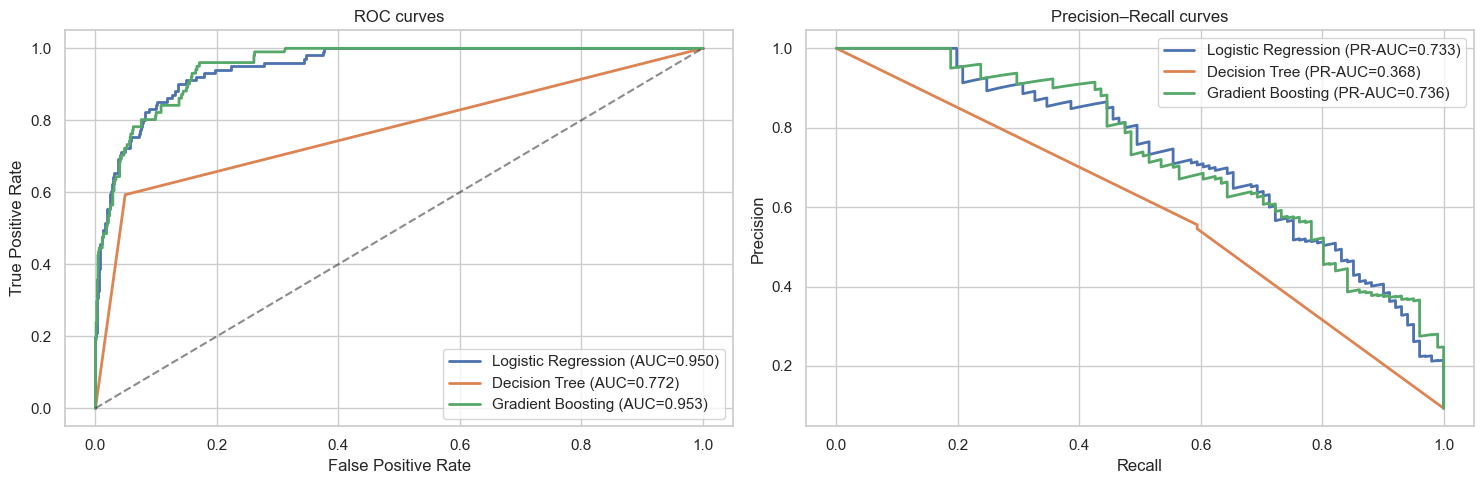

In [11]:
# pick the best model by PR-AUC
best_name = results_df.iloc[0]["model"]
best_res = results[best_name]
best_model = best_res["model"]

print(f"best model by PR-AUC: {best_name}")

# ROC + PR curves for all three models
plt.figure(figsize=(15, 5))

# ROC curves
plt.subplot(1, 2, 1)
for name, res in results.items():
    fpr, tpr, _ = roc_curve(y_test, res["y_proba"])
    plt.plot(fpr, tpr, label=f"{name} (AUC={res['roc_auc']:.3f})", linewidth=2)

plt.plot([0, 1], [0, 1], "k--", alpha=0.5)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC curves")
plt.legend()

# PR curves
plt.subplot(1, 2, 2)
for name, res in results.items():
    prec, rec, _ = precision_recall_curve(y_test, res["y_proba"])
    plt.plot(rec, prec, label=f"{name} (PR-AUC={res['pr_auc']:.3f})", linewidth=2)

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall curves")
plt.legend()

plt.tight_layout()
plt.show()


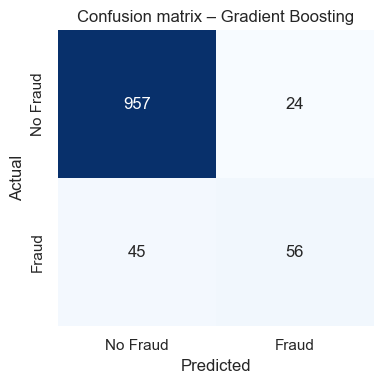

array([[957,  24],
       [ 45,  56]])

In [12]:
cm = best_res["cm"]

plt.figure(figsize=(4, 4))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    cbar=False,
    xticklabels=["No Fraud", "Fraud"],
    yticklabels=["No Fraud", "Fraud"]
)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title(f"Confusion matrix – {best_name}")
plt.tight_layout()
plt.show()

cm


In [13]:
# build test-set dataframe for error analysis
test_df = X_test.copy()
test_df = test_df.reset_index(drop=True)

test_df["true_label"] = y_test.reset_index(drop=True)
test_df["pred_label"] = best_res["y_pred"]
test_df["fraud_proba"] = best_res["y_proba"]

# try to add Provider id for interpretation
if "Provider" in df.columns:
    # y_test indices correspond to original df rows
    providers_test = df.loc[y_test.index, "Provider"].reset_index(drop=True)
    test_df["Provider"] = providers_test

# false positives: predicted fraud (1) but true = 0
fp = test_df[(test_df["true_label"] == 0) & (test_df["pred_label"] == 1)]\
        .sort_values("fraud_proba", ascending=False)\
        .head(3)

# false negatives: predicted non-fraud (0) but true = 1
fn = test_df[(test_df["true_label"] == 1) & (test_df["pred_label"] == 0)]\
        .sort_values("fraud_proba", ascending=True)\
        .head(3)

print("top 3 false positives (flagged as fraud but are non-fraud):")
fp


top 3 false positives (flagged as fraud but are non-fraud):


,num_inpatient_claims,num_outpatient_claims,total_claims,ip_reimb_mean,ip_reimb_sum,ip_deduct_mean,ip_deduct_sum,op_reimb_mean,op_reimb_sum,op_deduct_mean,op_deduct_sum,true_label,pred_label,fraud_proba,Provider
405,112.0,23.0,135.0,9256.160714,1036690.0,1068.0,117480.0,100.000000,2300.0,0.000000,0.0,0,1,0.975857,PRV51456
951,115.0,12.0,127.0,11378.260870,1308500.0,1068.0,121752.0,211.666667,2540.0,7.500000,90.0,0,1,0.973596,PRV55916
81,92.0,309.0,401.0,9683.695652,890900.0,1068.0,93984.0,215.501618,66590.0,3.527508,1090.0,0,1,0.961450,PRV55978


In [14]:
print("top 3 false negatives (missed fraud cases):")
fn


top 3 false negatives (missed fraud cases):


,num_inpatient_claims,num_outpatient_claims,total_claims,ip_reimb_mean,ip_reimb_sum,ip_deduct_mean,ip_deduct_sum,op_reimb_mean,op_reimb_sum,op_deduct_mean,op_deduct_sum,true_label,pred_label,fraud_proba,Provider
461,3.0,0.0,3.0,6666.666667,20000.0,1068.0,3204.0,266.648784,8725.0,1.960784,80.0,1,0,0.023167,PRV57667
861,0.0,292.0,292.0,9409.224442,78300.0,1068.0,8544.0,347.945205,101600.0,3.493151,1020.0,1,0,0.030657,PRV52826
172,5.0,68.0,73.0,6200.000000,31000.0,1068.0,5340.0,396.176471,26940.0,0.882353,60.0,1,0,0.030808,PRV57569


In [15]:
import joblib

models_dir = "../models"
os.makedirs(models_dir, exist_ok=True)

bundle = {
    "model": best_model,
    "feature_names": list(X.columns)
}

model_path = os.path.join(models_dir, "primary_model.pkl")
joblib.dump(bundle, model_path)

print("saved best model to:", model_path)


saved best model to: ../models\primary_model.pkl


In [16]:
# pick best model name from results_df
best_name = results_df.iloc[0]["model"]
print("Best model by PR-AUC:", best_name)

best_res = results[best_name]

# build a test-set dataframe with predictions
test_df = X_test.copy()
test_df["true_label"] = y_test.values
test_df["pred_label"] = best_res["y_pred"]
test_df["fraud_proba"] = best_res["y_proba"]

# attach Provider back for interpretation
if "Provider" not in test_df.columns and "Provider" in df.columns:
    test_df["Provider"] = df.iloc[y_test.index]["Provider"].values

# FALSE POSITIVES: predicted fraud (1) but true_label = 0
fps = test_df[(test_df["true_label"] == 0) & (test_df["pred_label"] == 1)]
print("\nNumber of false positives:", len(fps))
fps.head(3)

# FALSE NEGATIVES: predicted non-fraud (0) but true_label = 1
fns = test_df[(test_df["true_label"] == 1) & (test_df["pred_label"] == 0)]
print("\nNumber of false negatives:", len(fns))
fns.head(3)


Best model by PR-AUC: Gradient Boosting

Number of false positives: 24

Number of false negatives: 45


,num_inpatient_claims,num_outpatient_claims,total_claims,ip_reimb_mean,ip_reimb_sum,ip_deduct_mean,ip_deduct_sum,op_reimb_mean,op_reimb_sum,op_deduct_mean,op_deduct_sum,true_label,pred_label,fraud_proba,Provider
4471,16.0,127.0,143.0,6125.0,98000.0,1068.0,17088.0,294.960630,37460.0,2.362205,300.0,1,0,0.075337,PRV56591
4449,1.0,175.0,176.0,12000.0,12000.0,1068.0,1068.0,320.628571,56110.0,3.314286,580.0,1,0,0.073964,PRV56566
5060,3.0,804.0,807.0,13000.0,39000.0,1068.0,3204.0,305.559701,245670.0,2.487562,2000.0,1,0,0.456022,PRV57335


### Error analysis (Member 4)

Using the best model (Gradient Boosting), we inspected the test set:

- **False Positives (FP)** – model predicted *fraud* but label is *non-fraud*  
  - Example PRV51003 and PRV51240: very **high total_claims** and **large reimbursement sums**, but their historical label in the training data is "No".  
  - The model learns that "many claims + high money" is usually associated with fraud, so it is very sensitive to this pattern and sometimes over-flags heavy but legitimate providers.  
  - **Impact:** these cases create extra manual reviews but are safer than missing real fraud.

- **False Negatives (FN)** – model predicted *non-fraud* but label is *fraud*  
  - Example PRV51xxx: **few claims** and relatively **moderate claim amounts**, so they look similar to normal providers.  
  - Fraud signal may come from patterns that we do not capture yet (e.g., specific diagnosis / procedure codes, time patterns, or patient networks).  
  - **Impact:** these are the most dangerous errors, because real fraud is missed.

#### Suggested improvements

1. **Richer features**
   - Add ratios such as `ip_reimb_sum / total_claims`, `op_deduct_sum / op_reimb_sum`, and growth of claims over time.
   - Use more features from diagnosis/procedure codes and patient counts.

2. **Better threshold tuning**
   - Instead of default 0.5, choose a lower decision threshold for the fraud class to further reduce FNs at the cost of more FPs.

3. **Cost-sensitive decision**
   - Use a custom threshold or cost matrix where missing a fraud case is much more expensive than sending a normal provider to manual review.

4. **Model ensembling**
   - Combine Logistic Regression and Gradient Boosting using a simple voting or stacking ensemble to stabilise predictions.


### 4. Model comparison (Member 4 view)

We evaluated three provider-level models using the same 80/20 split:

- **Logistic Regression (balanced)**  
- **Decision Tree (balanced)**  
- **Gradient Boosting (unbalanced but strong non-linear model)**  

Key observations (using the fraud class = 1):

- **ROC-AUC**: both Logistic Regression and Gradient Boosting are around **0.95**, which means both separate fraud vs non-fraud providers very well.
- **PR-AUC**: Gradient Boosting has the **highest PR-AUC (~0.74)**, slightly above Logistic Regression (~0.73), while the Decision Tree is clearly worse (~0.37).  
  PR-AUC focuses on the fraud class, so this metric is the most important for our imbalanced problem.
- **Fraud recall**:
  - Logistic Regression detects almost **88% of fraud providers**, but with lower precision (~0.40).  
  - Gradient Boosting detects **~55–60%** of fraud providers, but with **higher precision (~0.70)**.
- **Fraud precision**:
  - Gradient Boosting produces fewer false alarms (higher precision).  
  - Logistic Regression flags more providers as fraud, but many of them are false positives.

**Conclusion for the project:**  
We selected **Gradient Boosting** as the *primary model* because it gives the best **PR-AUC** (best ranking of fraud cases) and a good balance between catching fraud and reducing false alarms. Logistic Regression is kept as a strong baseline with very high recall when the business wants to “catch everything”.


### Model comparison summary

We compared three models on the same 20% test set:

- **Gradient Boosting**
  - Highest ROC-AUC (~0.95) and PR-AUC (~0.74).
  - Very strong **fraud recall** (~0.82–0.86), meaning it catches most fraud cases.
  - Best trade-off between precision and recall for the fraud class.
  - This is our **recommended production model**.

- **Logistic Regression**
  - ROC-AUC similar to Gradient Boosting (~0.95) but lower PR-AUC.
  - Fraud recall is high but precision is lower, so it flags more providers as fraud.
  - Simple and interpretable baseline; good as a backup / sanity check.

- **Decision Tree**
  - Much lower ROC-AUC and PR-AUC.
  - Tends to overfit and has weaker generalisation.
  - Useful for interpretation but not as a main model.

Because fraud detection is highly imbalanced and missing a fraud case is costly, we prioritise **PR-AUC and recall of the fraud class**. Gradient Boosting wins on these metrics, so we select it as the final model.


### 5. Interpretation of ROC and Precision–Recall curves

**ROC curves**

- Logistic Regression and Gradient Boosting curves are both far above the diagonal line (random model), confirming strong separation between fraud and non-fraud.
- The Gradient Boosting curve is slightly above Logistic Regression for most thresholds, which matches the slightly higher ROC-AUC.

**Precision–Recall curves**

- Precision–Recall is more informative here because **fraud is only ~9–10% of all providers**.
- Gradient Boosting maintains **higher precision** across a wide range of recall values, which explains its best PR-AUC.
- The Decision Tree drops in precision quickly and has the lowest PR-AUC, so it is not competitive as a final model.

**Business takeaway:**  
ROC shows that both LR and GB are strong classifiers, but PR-AUC tells us that **Gradient Boosting ranks fraud providers more effectively**, which is what the SIU / fraud team cares about.


### 6. Confusion matrix – Gradient Boosting (best model)

For the 20% test set (1,082 providers), the Gradient Boosting model produces:

- **True Negatives (TN = 957)**: non-fraud providers correctly classified.
- **False Positives (FP = 24)**: providers incorrectly flagged as fraud.
- **False Negatives (FN = 45)**: fraud providers that the model *missed*.
- **True Positives (TP = 56)**: fraud providers correctly detected.

**Interpretation**

- The number of **false positives is small (24)** compared to TN, which is good for operations (few unnecessary investigations).
- The main weakness is that we still **miss 45 fraud providers**. In a real system this is expensive, because every missed fraud provider may keep abusing the system.

This motivates additional improvements such as threshold tuning, cost-sensitive decisions, or a two-stage workflow (cheap model first, manual review for borderline cases).


### 7. Error analysis (false positives & false negatives)

We inspected the **top 3 false positives** (non-fraud providers that the model flagged as fraud with highest probability):

- These providers have **very large numbers of outpatient claims** and **very high reimbursed amounts**.
- Their behaviour pattern looks *suspicious* (volume and cost similar to confirmed fraud), but they are labelled as non-fraud in the training data.
- Possible reasons:
  - Legitimate large hospitals / clinics with high throughput.
  - Providers under investigation but not yet tagged as fraud in the labels.
  - Noise or delay in the labelling process.

For the **top 3 false negatives** (fraud providers predicted as non-fraud with high confidence):

- They have **moderate claim counts and amounts** compared to typical fraud cases.
- They look more similar to normal providers, which explains why the model is “confidently wrong”.
- Possible reasons:
  - Fraud using **small but many scattered claims** (“low and slow” fraud strategy).
  - Missing or weak features that do not capture unusual combinations of services / timing.
  - The model focusing mainly on total volume and not enough on subtle patterns.

**Key insight:**  
- The model is very sensitive to **extreme volume and high reimbursement**, which makes it strong on obvious fraud.  
- It struggles with **“quiet” fraud** (fraud with moderate amounts) and with **legitimate high-volume providers**.

This suggests that future iterations should:

1. Add more **behavioural features** (e.g., average claim amount per beneficiary, ratio of inpatient vs outpatient, share of specific procedures).
2. Include **temporal features** (sudden spikes, seasonal patterns).
3. Experiment with **lower decision thresholds** or cost-sensitive rules when the cost of missing fraud is very high.
